# OctResNet-18 Training

Here we train the ResNet-18 network with Octave Convolution layers on the Tiny ImageNet challenge. We will eventually use the ResNet-50 network. We will eventually compare in terms of both accuracy and compute power expended.

## Setup

In [3]:
import os
import time
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets

import OctResNet

In [4]:
# Taken from 231n assignments
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Tiny ImageNet Data

We use the Tiny ImageNet database to benchmark some of our results. To download this dataset into your own workspace, run `$ wget http://cs231n.stanford.edu/tiny-imagenet-200.zip` from your command line. Then use the `$ unzip` command to unzip the dataset for use. The data directory should be `tiny-imagenet-200/`.

Information about Tiny ImageNet is located at https://tiny-imagenet.herokuapp.com/.

In [5]:
data_dir = 'tiny-imagenet-200/'

In [6]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Number of training examples in dataset: {}".format(len(image_datasets['train'])))
print("Number of validation examples in dataset: {}".format(len(image_datasets['val'])))

Number of training examples in dataset: 100000
Number of validation examples in dataset: 10000


In [7]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    
    Code from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Image shape: torch.Size([3, 224, 224])
Image class: 16


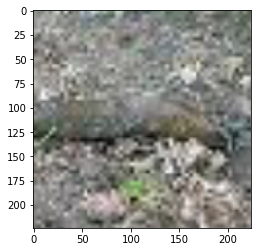

In [8]:
sample = image_datasets['val'][800]
print("Image shape: {}".format(sample[0].shape))
print("Image class: {}".format(sample[1]))
imshow(sample[0])

### Memory Profiling Tools

In [9]:
import gc
import sys
import operator as op
from functools import reduce

"""Code largely taken from  https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/8. 
Should print out the allocated memory for each of our tensors."""

def sizeof_fmt(num, suffix='B'):
    """
    Helper function to get human-readable bytes
    From https://stackoverflow.com/questions/1094841/reusable-library-to-get-human-readable-version-of-file-size
    """
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.5f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def print_mem_tensors(verbose=False):
    """Prints stats about Pytorch's memory usage"""
    total_tensors = 0
    total_elems = 0
    total_bytes = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                total_tensors += 1
                total_elems += obj.nelement()
                total_bytes += obj.element_size() * obj.nelement() # Size of tensor elements
                total_bytes += sys.getsizeof(obj) # Tensor overhead
                if verbose:
                    print(obj.nelement(), type(obj), obj.size())
        except:
            pass
    human_bytes = sizeof_fmt(total_bytes)
    print("In-memory tensors: {}, num_elements: {}, bytes: {}".format(total_tensors, total_elems, human_bytes))
    return total_tensors, total_elems, total_bytes

## Octave Convolution ResNet-18 Model

Build the OctResNet18 from a modified version of torchvision.models.ResNet

## Training OctResNet-18

In [10]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, save_path, log_file=None, scheduler=None, num_epochs=25, train_name='train', val_name='val'):
    """
    
    Parameters:
        model (Pytorch model): the model to train
        criterion (function): the loss function to optimize
        optimizer: a Pytorch optimizer object (e.g. Adam or SGD)
        save_path (string): the file to write the best model weights to at every validation step
        log_file (string): the file to write training stats (loss, accuracy history) to
        scheduler: learning rate schduler
        num_epochs (int): number of epochs to train
        train_name (string): can be set to 'train_mini' to train on mini set.
        val_name (string): can be set to 'val_mini' to validate on mini set
        
    Returns:
        The model with highest validation accuracy from our training history
    """
    since = time.time()

    model.to(device=device, dtype=dtype)    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = -1.0
    
    # clear log_file:
    if log_file:
        open(log_file, 'w').close()
        with open(log_file, 'a') as f:
            f.write("Using optimizer: {}\n\n".format(optimizer))
    print("Using optimizer: {}\n\n".format(optimizer))

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_name, val_name]:
            if phase == train_name:
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # Count iterations
            iter_count = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_name):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_name:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Print memory profiling stats
                print_mem_tensors()
                print()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print and log training stats
            epoch_summary = 'Epoch: {}, {} Loss: {:.4f} Acc: {:.4f}'.format(
                epoch, phase, epoch_loss, epoch_acc)
            print(epoch_summary)
            if log_file:
                with open(log_file, "a") as f:
                    f.write(epoch_summary + "\n")
            
            # deep copy the best model, save weights to file
            if phase == val_name and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), save_path)
                print("Saved best model to {}".format(save_path))

        print()

    # Print and log timing stats
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    if log_file:
        with open(log_file, "a") as f:
            f.write('Training complete in {:.0f}m {:.0f}s\n'.format(
                    time_elapsed // 60, time_elapsed % 60))
            f.write('Best val Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    counter[0] += 1
    return model

In [11]:
loss_fn = nn.CrossEntropyLoss()

num_epochs = 28 # training?
#momentum = 0.9 # Lol fuggit, Adam -John
learning_rate = 1e-4 # ResNet Paper
reg = 1e-4 # Resnet paper is 1e-4
best_model = None
del best_model
octresnet18 = OctResNet.tinyoctresnet18(pretrained=False, progress=True).to(device)
optimizer = torch.optim.Adam(octresnet18.parameters(), lr=learning_rate, weight_decay=reg)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # OctConv paper

best_resnet_path = 'saved_models/oct_res18.pth'
best_model = train_model(octresnet18, loss_fn, optimizer, best_resnet_path, log_file='logs/oct_res18.txt', scheduler=scheduler, num_epochs=num_epochs)

Using optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 0.0001
)


Epoch 0/27
----------


/opt/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:100: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In-memory tensors: 1118, num_elements: 53610056, bytes: 204.58348MB

In-memory tensors: 1116, num_elements: 51201592, bytes: 195.39572MB

In-memory tensors: 1116, num_elements: 51201592, bytes: 195.39572MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1116, num_elements: 51201592, bytes: 195.39572MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1116, num_elements: 51201592, bytes: 195.39572MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1114, num_elements: 48793128, bytes: 186.20796MB

In-memory tensors: 1114, num_eleme

KeyboardInterrupt: 